In [1]:
import networkx as nx
import infomap
import numpy as np
import pandas as pd
from analysis import mkPartition

# Create the network

In [2]:
G = nx.Graph()
G.add_edges_from([ ("1","2"), ("1","3"), ("1","4"), ("2","4"), ("3","4") # left module
                 , ("4","5")                                             # bridge
                 , ("5","6"), ("5","7"), ("5","8"), ("6","7")            # right module
                 ])

In [3]:
pos = { "1" : [1,2]
      , "2" : [0,1]
      , "3" : [1,0]
      , "4" : [2,1]
      , "5" : [3,1]
      , "6" : [4,2]
      , "7" : [4,1]
      , "8" : [4,0]
      }

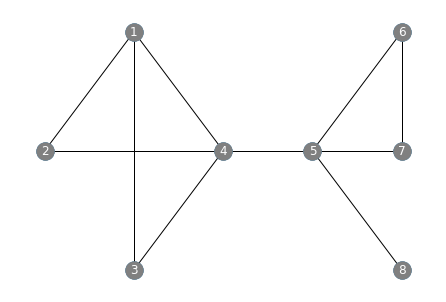

In [4]:
nx.draw(G, pos = pos)
_ = nx.draw_networkx_nodes(G, pos = pos, node_color = "grey")
_ = nx.draw_networkx_labels(G, pos = pos, font_color = "white")

# Calculate centralities

In [5]:
im_one_level = infomap.Infomap(silent = True, no_infomap = True)
node_mapping = im_one_level.add_networkx_graph(G)
im_one_level.run()

one_level_centralities = pd.Series({ node_mapping[node.node_id] : node.modular_centrality for node in im_one_level.iterLeafNodes()}, name = "$M_1$")

In [6]:
im = infomap.Infomap(silent = True, two_level = True, num_trials = 100)
node_mapping = im.add_networkx_graph(G)
im.run()
im.write_tree("toy-optimal.tree")

optimal_centralities = pd.Series({ node_mapping[node.node_id] : node.modular_centrality for node in im.iterLeafNodes() }, name = "$M_{opt}$")

In [7]:
mkPartition(im)

{1: {'1', '2', '3', '4'}, 2: {'5', '6', '7', '8'}}

In [8]:
partition = [{"1","2","3"}, {"4","5","6","7","8"}]

tree = dict()

# read the tree file
with open("toy-optimal.tree", "r") as fh:
    for line in fh:
        if not line.startswith("#"):
            _, flow, name, node_id = line.strip().split(" ")
            name = name[1:-1]
            tree[name] = (flow, node_id)

# write the Louvain partition to an Infomap tree file
with open("toy-suboptimal.tree", "w") as fh:
    for community_ID, community in enumerate(partition, start = 1):
        for node_pos, node in enumerate(community, start = 1):
            path = f"{community_ID}:{node_pos}"
            flow, node_id = tree[node]
            fh.write(f"{path} {flow} \"{node}\" {node_id}\n")


im_sub = infomap.Infomap(silent = True, no_infomap = True, cluster_data = "toy-suboptimal.tree")
node_mapping = im_sub.add_networkx_graph(G)
im_sub.run()

suboptimal_centralities = pd.Series({ node_mapping[node.node_id] : node.modular_centrality for node in im_sub.iterLeafNodes() }, name = "$M_{sub}$")

In [9]:
mkPartition(im_sub)

{2: {'1', '2', '3'}, 1: {'4', '5', '6', '7', '8'}}

In [10]:
pd.concat( [ pd.DataFrame(index = sorted(G.nodes))
           , pd.Series(nx.algorithms.centrality.degree_centrality(G), name = "DC")
           , pd.Series(nx.algorithms.centrality.betweenness_centrality(G), name = "BC")
           , pd.Series(nx.pagerank(G, alpha = 1), name = "PR")
           , one_level_centralities
           , suboptimal_centralities
           , optimal_centralities
           ]
         , axis = 1
         )

,DC,BC,PR,$M_1$,$M_{sub}$,$M_{opt}$
1,0.428571,0.023810,0.149994,0.199295,0.161471,0.183773
2,0.285714,0.000000,0.099996,0.136803,0.121357,0.130278
3,0.285714,0.000000,0.099996,0.136803,0.121357,0.130278
4,0.571429,0.595238,0.199995,0.257542,0.238732,0.228227
5,0.571429,0.666667,0.200007,0.257542,0.238732,0.211999
6,0.285714,0.000000,0.100005,0.136803,0.132554,0.126900
7,0.285714,0.000000,0.100005,0.136803,0.132554,0.126900
8,0.142857,0.000000,0.050002,0.070301,0.069286,0.067970
